In [1]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [2]:
whos

Interactive namespace is empty.


In [3]:
!free -g

              total        used        free      shared  buff/cache   available
Mem:            187          10         172           3           4         172
Swap:            11           1          10


In [4]:
!nvidia-smi

Tue Sep 14 14:42:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   40C    P0    66W / 300W |      3MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   

|   3  Tesla V100-SXM2...  On   | 00000000:AF:00.0 Off |                    0 |
| N/A   40C    P0    68W / 300W |      3MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+


In [5]:
import nvidia_smi
try:
    nvidia_smi.nvmlInit()

    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
    # card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

    print("Total memory:", (info.total/1024/1024/1024))
    print("Free memory:", (info.free/1024/1024/1024))
    print("Used memory:", (info.used/1024/1024/1024))

    nvidia_smi.nvmlShutdown()
except:
    pass

Total memory: 15.78173828125
Free memory: 15.7783203125
Used memory: 0.00341796875


In [6]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

from functools import partial
from tqdm import tqdm
from umap import UMAP
tqdm = partial(tqdm, position=0, leave=True) 

In [7]:
df = pd.read_csv('../Data/ABIDE_df2.csv')
df = df.iloc[~pd.isna(df['bids_folder']).values]
#data_dir = '../Assets/fc_mats/'
#data_dir = '../Assets/fc_mats_32smooth/'
data_dir = '../Assets/fc_mats_32smooth_new/'

In [8]:
files = [file for file in os.listdir(data_dir) if file.endswith('.npy')]
files.sort()
files[0:5]

['sub-CMUa0050642.npy',
 'sub-CMUa0050646.npy',
 'sub-CMUa0050647.npy',
 'sub-CMUa0050649.npy',
 'sub-CMUa0050653.npy']

In [9]:
subs_with_matFiles = [file.split('.')[0] for file in files]
df = df.iloc[np.array([sub in subs_with_matFiles for sub in df['bids_folder'].values])]
n_subs = len(df)
print(n_subs)

1048


In [10]:
# Check if subject has .nii file
has_file = np.array([os.path.exists(os.path.join(data_dir,sub + '.npy')) for sub in df['bids_folder'].values])
print(has_file.mean())
assert has_file.mean()==1.0, 'fuck'

1.0


In [11]:
assert len(subs_with_matFiles)==len(df),'no'
df = df.sort_values(by='bids_folder')
assert all([subs_with_matFiles[i]==df['bids_folder'].values[i] for i in range(n_subs)]), 'out of order'

In [12]:
df.index = np.arange(n_subs)

In [13]:
# %%time 
# # LOAD DATA
# n_subs = len(df)
# data_size = np.hstack((n_subs,np.load(os.path.join(data_dir,df['bids_folder'].values[0] + '.npz'))['data'].shape))
# data = np.zeros(data_size)
# #for s in tqdm(range(len(df))):
# for s in range(n_subs):
#     sub = df['bids_folder'].values[s]
#     datum = np.load(os.path.join(data_dir,sub + '.npz'))['data']
#     data[s,:,:,:,:] = datum

In [14]:
# hasnans = np.array([np.isnan(data[s,:,:,:,:]).sum()!=0 for s in range(data.shape[0])])
# df = df.iloc[~hasnans]
# data = data[~hasnans,:,:,:,:]

In [15]:
#data.shape

In [16]:
#assert np.isnan(data).mean()==0.0, 'you f****d up'

In [17]:
# plt.figure(figsize=(20,4.9))
# plt.subplot(1,4,1);plt.imshow(data[10,:,:,20,0]);plt.xticks([]);plt.yticks([]);
# plt.subplot(1,4,2);plt.imshow(data[np.random.randint(0,data.shape[0]),:,:,20,0]);plt.xticks([]);plt.yticks([]);
# plt.subplot(1,4,3);plt.imshow(data[np.random.randint(0,data.shape[0]),20,:,:,0]);plt.xticks([]);plt.yticks([]);
# #plt.subplot(1,4,4);plt.imshow(data[np.random.randint(0,data.shape[0]),:,20,:,0]);plt.xticks([]);plt.yticks([]);
# plt.subplot(1,4,4);plt.hist(data[0,:,:,:,:].flatten());

In [18]:
%%time
from helper_funcs import *
from importlib import reload
import make_models
reload(make_models)
del make_models
from make_models import *

from IPython import display
import sys
from sklearn.decomposition import PCA
import seaborn as sns

import tensorflow as tf
reload(tf)

CPU times: user 52.2 ms, sys: 9.07 ms, total: 61.2 ms
Wall time: 218 ms


<module 'tensorflow' from '/data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/__init__.py'>

In [19]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [20]:
class cvae_data_loader():
    ''' this is the info'''
    def __init__(self,data_dir,df,batch_size=32):
        #self.data = data
        #self.n = data.shape[0]
        self.n = len(df)
        self.data_dir = data_dir
        self.epoch = -1
        self.batch_size = batch_size
        self.df = df
        
        self.new_epoch()
        self.n_batches = int(np.floor(min((len(self.asd_idxs),len(self.td_idxs)))/self.batch_size))
        
    def new_epoch(self):
        self.df = self.df.iloc[np.random.permutation(np.arange(self.n))]
        self.df.index = np.arange(self.n)
        self.asd_idxs = np.nonzero((df['DX_GROUP'].values==1))[0]
        self.td_idxs = np.nonzero((df['DX_GROUP'].values==2))[0]
        self.epoch += 1
        self.b = 0
        
        
    def get_batch(self):
        self.b += 1
        
        if self.b==self.n_batches:
            self.new_epoch()
        
        
        self.batch_asd_idx = self.asd_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        self.batch_td_idx = self.td_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        self.batch_asd = np.array([np.load(os.path.join(self.data_dir,val+'.npy')) for val in self.df['bids_folder'].values[self.batch_asd_idx]])
        self.batch_td = np.array([np.load(os.path.join(self.data_dir,val+'.npy')) for val in self.df['bids_folder'].values[self.batch_td_idx]])
        self.batch_df = self.df.iloc[np.hstack((self.batch_asd_idx,self.batch_td_idx)),:]
        
        self.batch_asd = self.batch_asd/2
        self.batch_td = self.batch_td/2
        
    
        return self.batch_asd,self.batch_td,self.batch_df

In [21]:
data_dir = '../Assets/fc_mats_32smooth_new'
data_loader = cvae_data_loader(data_dir=data_dir, df=df, batch_size=32)
batch_asd,batch_td,batch_df = data_loader.get_batch()

In [22]:
data_size = np.hstack((n_subs,batch_asd.shape[1:]))

In [23]:
import make_models
reload(make_models)
from make_models import *
batch_size = 32
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(input_shape=tuple(data_size[1::]),
                   latent_dim = 8, 
                   batch_size = batch_size, 
                   disentangle = True, 
                   gamma = 1,
                   kernel_size = 3,
                   filters = 8,
                   intermediate_dim = 128,
                   nlayers = 2,
                   learning_rate=0.001)

In [24]:
tuple(data_size)

(1048, 32, 32, 32, 51)

In [25]:
patients = df['DX_GROUP'].values==1
controls = df['DX_GROUP'].values==2

In [26]:
loss = list()
c_sim = list()
all_rsas = list()

In [27]:
tf.__version__

'2.3.1'

In [28]:
def fit_rsa(rdm_data,rdm_model):
    return np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]

In [29]:
def get_batch_rsas(z_encoder,s_encoder,df,n=400):
    
    #patient_batch,control_batch

    asd_idx = np.nonzero(~np.isnan(batch_df['DX_GROUP'].values==1))

    #z_embedding = z_encoder.predict(data[patients,:,:,:,:][asd_idx,:,:,:,:])[2]
    #s_embedding = s_encoder.predict(data[patients,:,:,:,:][asd_idx,:,:,:,:])[2]
    
    z_embedding = z_encoder.predict(patient_batch)[2]
    s_embedding = s_encoder.predict(patient_batch)[2]

    rdm_age = make_RDM(batch_df['AGE_AT_SCAN'].values[patients][asd_idx])
    rdm_sex = make_RDM(batch_df['SEX'].values[patients][asd_idx],data_scale='ordinal')
    rdm_fiq = make_RDM(batch_df['FIQ'].values[patients][asd_idx])
    rdm_dsm = make_RDM(batch_df['DSM_IV_TR'].values[patients][asd_idx],data_scale='ordinal')
    rdm_site = make_RDM(batch_df['site'].values[patients][asd_idx],data_scale='ordinal')
    #rdm_adosTotal = make_RDM(batch_df['ADOS_TOTAL'].values[patients][asd_idx])

    rdm_z = make_RDM(z_embedding)
    rdm_s = make_RDM(s_embedding)

    batch_rsas = list()

    batch_rsas.append(fit_rsa(rdm_s,rdm_age))
    batch_rsas.append(fit_rsa(rdm_s,rdm_sex))
    batch_rsas.append(fit_rsa(rdm_s,rdm_fiq))
    batch_rsas.append(fit_rsa(rdm_s,rdm_dsm))
    batch_rsas.append(fit_rsa(rdm_s,rdm_site))
    #batch_rsas.append(fit_rsa(rdm_s,rdm_adosTotal))

    batch_rsas.append(fit_rsa(rdm_z,rdm_age))
    batch_rsas.append(fit_rsa(rdm_z,rdm_sex))
    batch_rsas.append(fit_rsa(rdm_z,rdm_fiq))
    batch_rsas.append(fit_rsa(rdm_z,rdm_dsm))
    batch_rsas.append(fit_rsa(rdm_z,rdm_site))
    #batch_rsas.append(fit_rsa(rdm_z,rdm_adosTotal))
    
    return batch_rsas

In [30]:
def cvae_dashboard(i,cvae,z_encoder,s_encoder,loss,all_rsas,c_sim,df,patient_batch,control_batch,red='UMAP'):
    

    if red=='PCA':
        reducer = PCA
    elif red=='UMAP':
        reducer = UMAP
    else:
        reducer = UMAP
        
    #prediction = cvae.predict(patient_batch)    
    predictions = cvae.predict([patient_batch,control_batch])
    #predictions = np.concatenate((predictions[0],predictions[1]),axis=0)
    prediction = predictions[0]
    
    if np.mod(i,1)==0:        
        pc_s = reducer(n_components=2).fit_transform(s_encoder.predict(np.concatenate((patient_batch,control_batch),axis=0))[2])
        pc_z = reducer(n_components=2).fit_transform(z_encoder.predict(np.concatenate((patient_batch,control_batch),axis=0))[2])
        
        global pc_s_asd, pc_s_td, pc_z_asd, pc_z_td

        pc_s_asd = pc_s[0:patient_batch.shape[0],:]
        pc_s_td = pc_s[patient_batch.shape[0]::,:]

        pc_z_asd = pc_z[0:patient_batch.shape[0],:]
        pc_z_td = pc_z[patient_batch.shape[0]::,:]
        
        #all_rsas.append(get_batch_rsas(z_encoder,s_encoder,df,n=50))
        
    cmat_actual = np.corrcoef(np.vstack((patient_batch.reshape(patient_batch.shape[0],-1),control_batch.reshape(control_batch.shape[0],-1))))
    cmat_pred = np.corrcoef(np.vstack((predictions[0].reshape(predictions[0].shape[0],-1),predictions[1].reshape(predictions[1].shape[0],-1))))
    c_sim.append(np.corrcoef(get_triu(cmat_pred),get_triu(cmat_actual))[0,1])

    
    ### PROGRESS PLOTTING
    display.clear_output(wait=True);
    display.display(plt.gcf());
    #Organise figure
    ncols = 4;nrows=5
    if np.mod(i,5)==0:
        plt.close()
    plt.subplots(nrows,ncols,figsize=(15,15)); # MAKE THE FIGURE
    
    
    ##### SUBPLOT 1 & 2 ##### 

    plt.subplot(nrows,ncols/2,1) # PLOT LOSS
    xs = np.arange(len(loss))+1
    m,b = np.polyfit(xs,loss,deg=1)
    plt.plot(loss)
    plt.plot(xs, m*xs + b)
    plt.title(f'Loss {hist:.2f}, beta: {m:.4f}')
    
    ##### SUBPLOT 3 ##### 
    plt.subplot(nrows,ncols,3) # PLOT LOSS LAST 50
    hb = 50
    if len(loss)>hb:
        plot_loss = loss[-hb::]
        xs = np.arange(len(plot_loss))
        m,b = np.polyfit(xs,plot_loss,deg=1)
        plt.plot(plot_loss)
        plt.plot(xs, m*xs + b)
        #plt.title(hist)
        plt.title(f'Loss last {hb} it, beta {m:.4f}')
        
    ##### SUBPLOT 4 ##### 
    plt.subplot(nrows,ncols,4)
    plt.hist(prediction[0,:,:,:,0].flatten(),alpha=.5)
    plt.hist(patient_batch[0,:,:,:,0].flatten(),alpha=.5)
    plt.legend(['predicted','actual'])
    plt.title('in/out histograms')
    
    ##### SUBPLOT 5 ##### 
    plt.subplot(nrows,ncols,5) #RSA over time
    plt.plot(c_sim)
    plt.title(f'in/out RSA: {c_sim[-1].round(2)}')
    
    if len(c_sim)>5: # PLOT LS LINE
        xs = np.arange(len(c_sim))+1
        m,b = np.polyfit(xs,c_sim,deg=1)
        plt.plot(xs, m*xs + b)
        plt.title(f'in/out RSA: {c_sim[-1].round(2)}, b={m:.4f}')
        

    ##### SUBPLOT 6 ##### 
    plt.subplot(nrows,ncols,6)
    if len(c_sim)>hb:
        #plot_loss = loss[-hb::]
        xs = np.arange(len(c_sim[-hb::]))
        m,b = np.polyfit(xs,c_sim[-hb::],deg=1)
        plt.plot(c_sim[-hb::])
        plt.plot(xs, m*xs + b)
        #plt.title(hist)
        plt.title(f'in/outRSA last {hb} it, b={m:.4f}')

    ##### SUBPLOT 7 ##### 
    plt.subplot(nrows,ncols,7)
    if len(all_rsas)>5:
        ys = np.array(all_rsas)[:,np.array((2))]
        plt.plot(ys,'-');
        plt.legend(['FIQ'],loc=2)

        xs = np.arange(len(ys))+1
        m,b = np.polyfit(xs,ys,deg=1)
        plt.plot(xs, m*xs + b)
        plt.title(f'S RSA: {ys[-1]:2f},b={m:.4f}')
    
    ##### SUBPLOT 8 ##### 
    plt.subplot(nrows,ncols,8)
    if len(all_rsas)>5:
        ys = np.array(all_rsas)[:,np.array((5))]
        plt.plot(ys,'-');
        plt.legend(['Age'],loc=2)
        xs = np.arange(len(ys))+1
        m,b = np.polyfit(xs,ys,deg=1)
        plt.plot(xs, m*xs + b)
        plt.title(f'Z RSA: {ys[-1]:2f},b={m:.4f}')
        
    ##### SUBPLOT 9 ##### 
    plt.subplot(nrows,ncols,9)
    plt.scatter(pc_s_asd[:,0],pc_s_asd[:,1],s=100,alpha=.5);plt.title(f'batch latent S rep. {red}')
    plt.scatter(pc_s_td[:,0],pc_s_td[:,1],s=100,alpha=.5);plt.title(f'batch latent S rep. {red}')
    plt.legend(['ASD','TD'])
    
    ##### SUBPLOT 10 ##### 
    plt.subplot(nrows,ncols,10)
    plt.scatter(pc_z_asd[:,0],pc_z_asd[:,1],s=100,alpha=.5);plt.title(f'batch latent Z rep. {red}')
    plt.scatter(pc_z_td[:,0],pc_z_td[:,1],s=100,alpha=.5);plt.title(f'batch latent Z rep. {red}')
    plt.legend(['ASD','TD'])
    
    ##### SUBPLOT 11 ##### 
    plt.subplot(nrows,ncols,11)
    sns.heatmap(cmat_actual,xticklabels=[],yticklabels=[])
    plt.title('input RSA')
        
    ##### SUBPLOT 12 ##### 
    plt.subplot(nrows,ncols,12)
    sns.heatmap(cmat_pred,xticklabels=[],yticklabels=[])
    plt.title('output RSA')
  
    ##### SUBPLOT 13 #####     
    plt.subplot(nrows,ncols,13)
    plt.imshow(np.rot90(patient_batch[0,:,16,:,0]))
    plt.xticks([]);plt.yticks([]);plt.title('actual')

    ##### SUBPLOT 14 #####     
    plt.subplot(nrows,ncols,14)
    plt.imshow(np.rot90(prediction[0,:,16,:,0]))
    plt.xticks([]);plt.yticks([]);plt.title('predicted')
    ##### SUBPLOT 15 #####     
    plt.subplot(nrows,ncols,15)
    plt.imshow(np.rot90(patient_batch[0,16,:,:,0]))
    plt.xticks([]);plt.yticks([]);plt.title('actual')
    ##### SUBPLOT 16 #####                                             
    plt.subplot(nrows,ncols,16)
    plt.imshow(np.rot90(prediction[0,16,:,:,0]))
    plt.xticks([]);plt.yticks([]);plt.title('predicted')
    ##### SUBPLOT 17 #####     
    plt.subplot(nrows,ncols,17)
    plt.imshow(np.rot90(patient_batch[0,6,:,:,0]))
    plt.xticks([]);plt.yticks([]);plt.title('actual')
    ##### SUBPLOT 18 #####                                             
    plt.subplot(nrows,ncols,18)
    plt.imshow(np.rot90(prediction[0,6,:,:,0]))
    plt.xticks([]);plt.yticks([]);plt.title('predicted')
    ##### SUBPLOT 19 #####     
    plt.subplot(nrows,ncols,19)
    plt.imshow(patient_batch[0,:,:,16,0])
    plt.xticks([]);plt.yticks([]);plt.title('actual')
    ##### SUBPLOT 20 #####     
    plt.subplot(nrows,ncols,20)
    plt.imshow(prediction[0,:,:,16,0])
    plt.xticks([]);plt.yticks([]);plt.title('predicted')
    
    plt.tight_layout()
    plt.show()
    #sys.stdout.flush()
    
    return c_sim,all_rsas

In [31]:
data_loader = cvae_data_loader(data_dir=data_dir, df=df, batch_size=32)

<Figure size 432x288 with 0 Axes>

<ipython-input-30-6101d3b1b3b9>:47: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrows,ncols/2,1) # PLOT LOSS


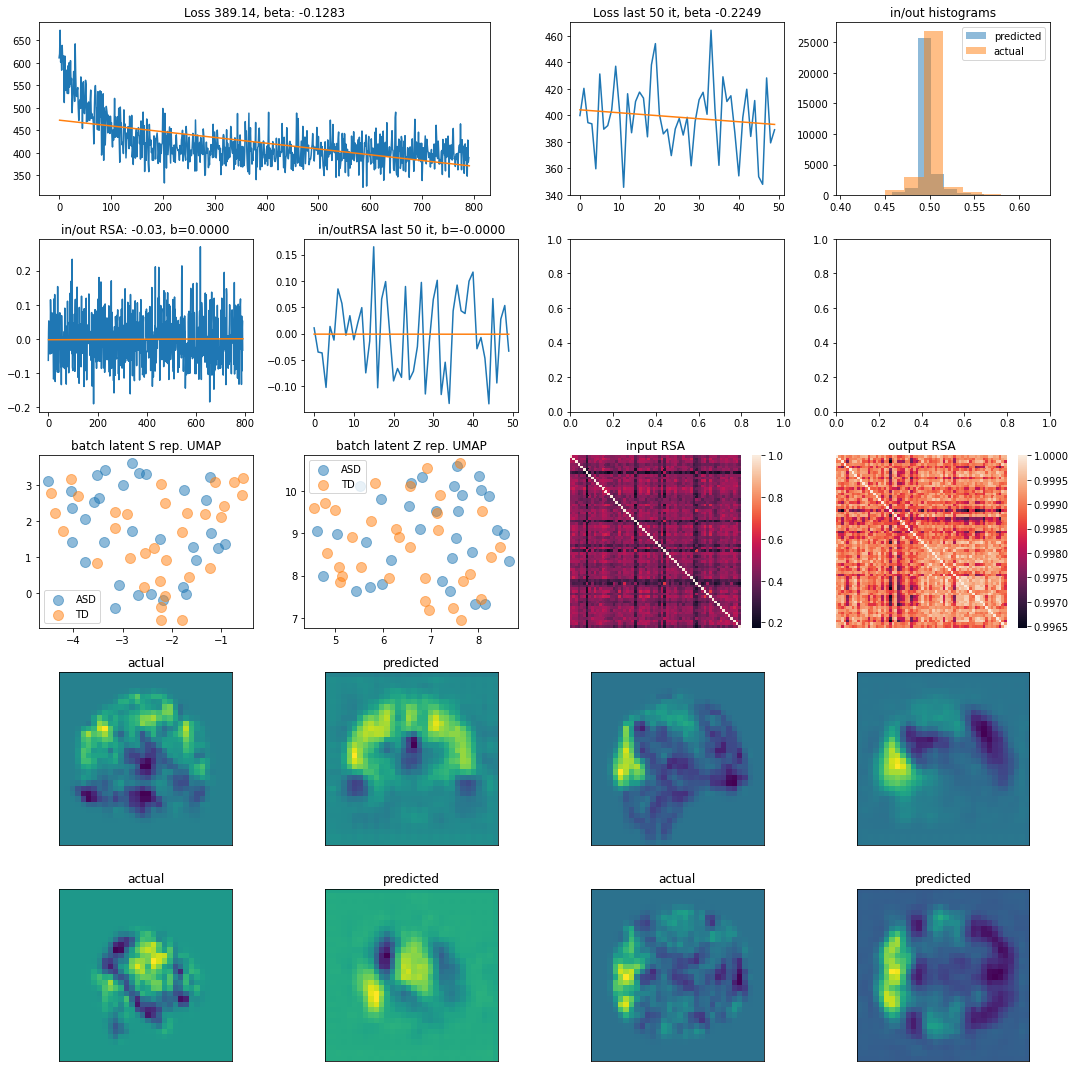

  8%|▊         | 791/10000 [2:34:31<29:38:15, 11.59s/it]

In [32]:
for epoch in range(5):
    for i in tqdm(range(10000),position=0, leave=True):
        #patient_batch = data[patients,:,:,:,:][np.random.randint(low=0,high=patients.sum(),size=batch_size),:,:,:,:]
        #control_batch = data[controls,:,:,:,:][np.random.randint(low=0,high=controls.sum(),size=batch_size),:,:,:,:]
        patient_batch,control_batch,batch_df = data_loader.get_batch()
        hist = cvae.train_on_batch([patient_batch,control_batch])
        assert not np.isnan(hist),'loss is NaN - you f**cked up'    
        loss.append(hist)
        
        c_sim,all_rsas = cvae_dashboard(i,cvae,z_encoder,s_encoder,loss,all_rsas,c_sim,df,patient_batch,control_batch,red='UMAP')